## Import libraries and setup folders

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pickle
import itertools
import py3Dmol
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from scipy.stats import pearsonr, linregress
from Bio.PDB import PDBIO, PDBParser
from metfish.utils import get_rmsd, get_lddt, align_structures

In [2]:
# set paths for different experimental and alphafold output files
working_dir = '//pscratch//sd//s//smprince//projects//metfish//data'
output_dir = f'{working_dir}//output//240311/predictions'
experimental_dir = f'{working_dir}//pdbs'

# load pair dataframe
pair_df = pd.read_csv(f'{working_dir}//pdbs_raw//apo_holo_pairs.csv')

## Effects of structure recycling input
Two types of alphafold inference runs were performed. In one, alphafold was run on sequences that have multiple known experimental conformations (apo and holo) with no modification. In the other, the structural representation alphafold output (atom positions) was replaced during the recycling process with the known experimental values from pdb structure files.

### Data setup

In [3]:
# define data collating function
def create_manipulation_df(conformers, pairs, experimental_dir, af_output_dir, manipulation='none'):
    conf_data = []
    for conf in conformers:
        # add 'pair_id' value to all conformer pairs
        pair_id = [ind for ind, p in enumerate(pairs) if conf in p][0]  
        
        # get opposite conformer (set difference)
        alt_conf = [(set(p) - {conf}).pop() for p in pairs if conf in p][0]            
        
        # get the pdb/experimental data structure filename 
        exp_same_conformer = f'{experimental_dir}//{conf}_atom_only.pdb'                
        exp_alt_conformer = f'{experimental_dir}//{alt_conf}_atom_only.pdb'
        
        # find filenames of the first model over all recycling iterations
        if any(glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')):            
            af_fnames = glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')
        else:
            af_fnames = glob.glob(f'{af_output_dir}//{alt_conf}*rank_001*.r[0-9].pdb')  
        
        # get recycling iteration values
        recycling_iter = [int(f.split('.pdb')[0][-1]) for f in af_fnames]              
        
        # calculate rmsd between recycling iteration and experimental data
        rmsd_same = [get_rmsd(exp_same_conformer, af) for af in af_fnames]             
        rmsd_alt = [get_rmsd(exp_alt_conformer, af) for af in af_fnames]
        
        conf_data.append(pd.DataFrame(dict(name=conf, 
                                           recycling_iteration=recycling_iter, 
                                           rmsd_same=rmsd_same,
                                           rmsd_alt=rmsd_alt,
                                           alt_conf=alt_conf,
                                           pair_id=pair_id,
                                           manipulation=manipulation,
                                           af_fname=af_fnames, 
                                           exp_same_fname=exp_same_conformer, 
                                           exp_alt_fname=exp_alt_conformer,)))
    return conf_data

In [51]:
# create conformer dataframes
output_dir_with_no_manipulation = f'{working_dir}//output//no_manipulation//240213'
output_dir_with_manipulation = f'{working_dir}//output//replace_conformer//240213'
pair_df_with_similarity = pd.read_csv(f'{working_dir}//apo_holo_pairs_with_similarity.csv')

pairs = list(zip(pair_df_with_similarity['apo_id'], pair_df_with_similarity['holo_id']))
conformers = [conf for p in pairs for conf in p]
less_similar_conformer = pair_df_with_similarity['less_similar_conformer'].to_list()
df_no_maniplation = create_manipulation_df(conformers, 
                                           pairs, 
                                           experimental_dir, 
                                           output_dir_with_no_manipulation,
                                           manipulation='none')
df_with_manipulation = create_manipulation_df(conformers, 
                                              pairs, 
                                              experimental_dir, 
                                              output_dir_with_manipulation, 
                                              manipulation='template')

conf_df = pd.concat([*df_no_maniplation, *df_with_manipulation])
conf_df = conf_df.sort_values(['pair_id', 'name','manipulation', 'recycling_iteration'])
conf_df.head()

name  recycling_iteration  rmsd_same   rmsd_alt      lddt alt_conf  \
5  4LP5_A                    0   8.930768  10.996714  0.644444   4P2Y_A   
0  4LP5_A                    1   9.031797  10.002702  0.652324   4P2Y_A   
4  4LP5_A                    2   8.558395   9.969888  0.654314   4P2Y_A   
3  4LP5_A                    3   8.508500   9.605280  0.654905   4P2Y_A   
2  4LP5_A                    4   8.313478   9.235455  0.655184   4P2Y_A   

   pair_id manipulation                                           af_fname  \
5        0         none  //pscratch//sd//s//smprince//projects//metfish...   
0        0         none  //pscratch//sd//s//smprince//projects//metfish...   
4        0         none  //pscratch//sd//s//smprince//projects//metfish...   
3        0         none  //pscratch//sd//s//smprince//projects//metfish...   
2        0         none  //pscratch//sd//s//smprince//projects//metfish...   

                                      exp_same_fname  \
5  //pscratch//sd//s//smprince//projects//metfish...   
0  //pscratch//sd//s//smprince//projects//metfish...   
4  //pscratch//sd//s//smprince//projects//metfish...   
3  //pscratch//sd//s//smprince//projects//metfish...   
2  //pscratch//sd//s//smprince//projects//metfish...   

                                       exp_alt_fname  
5  //pscratch//sd//s//smprince//projects//metfish...  
0  //pscratch//sd//s//smprince//projects//metfish...  
4  //pscratch//sd//s//smprince//projects//metfish...  
3  //pscratch//sd//s//smprince//projects//metfish...  
2  //pscratch//sd//s//smprince//projects//metfish...

### Visualization

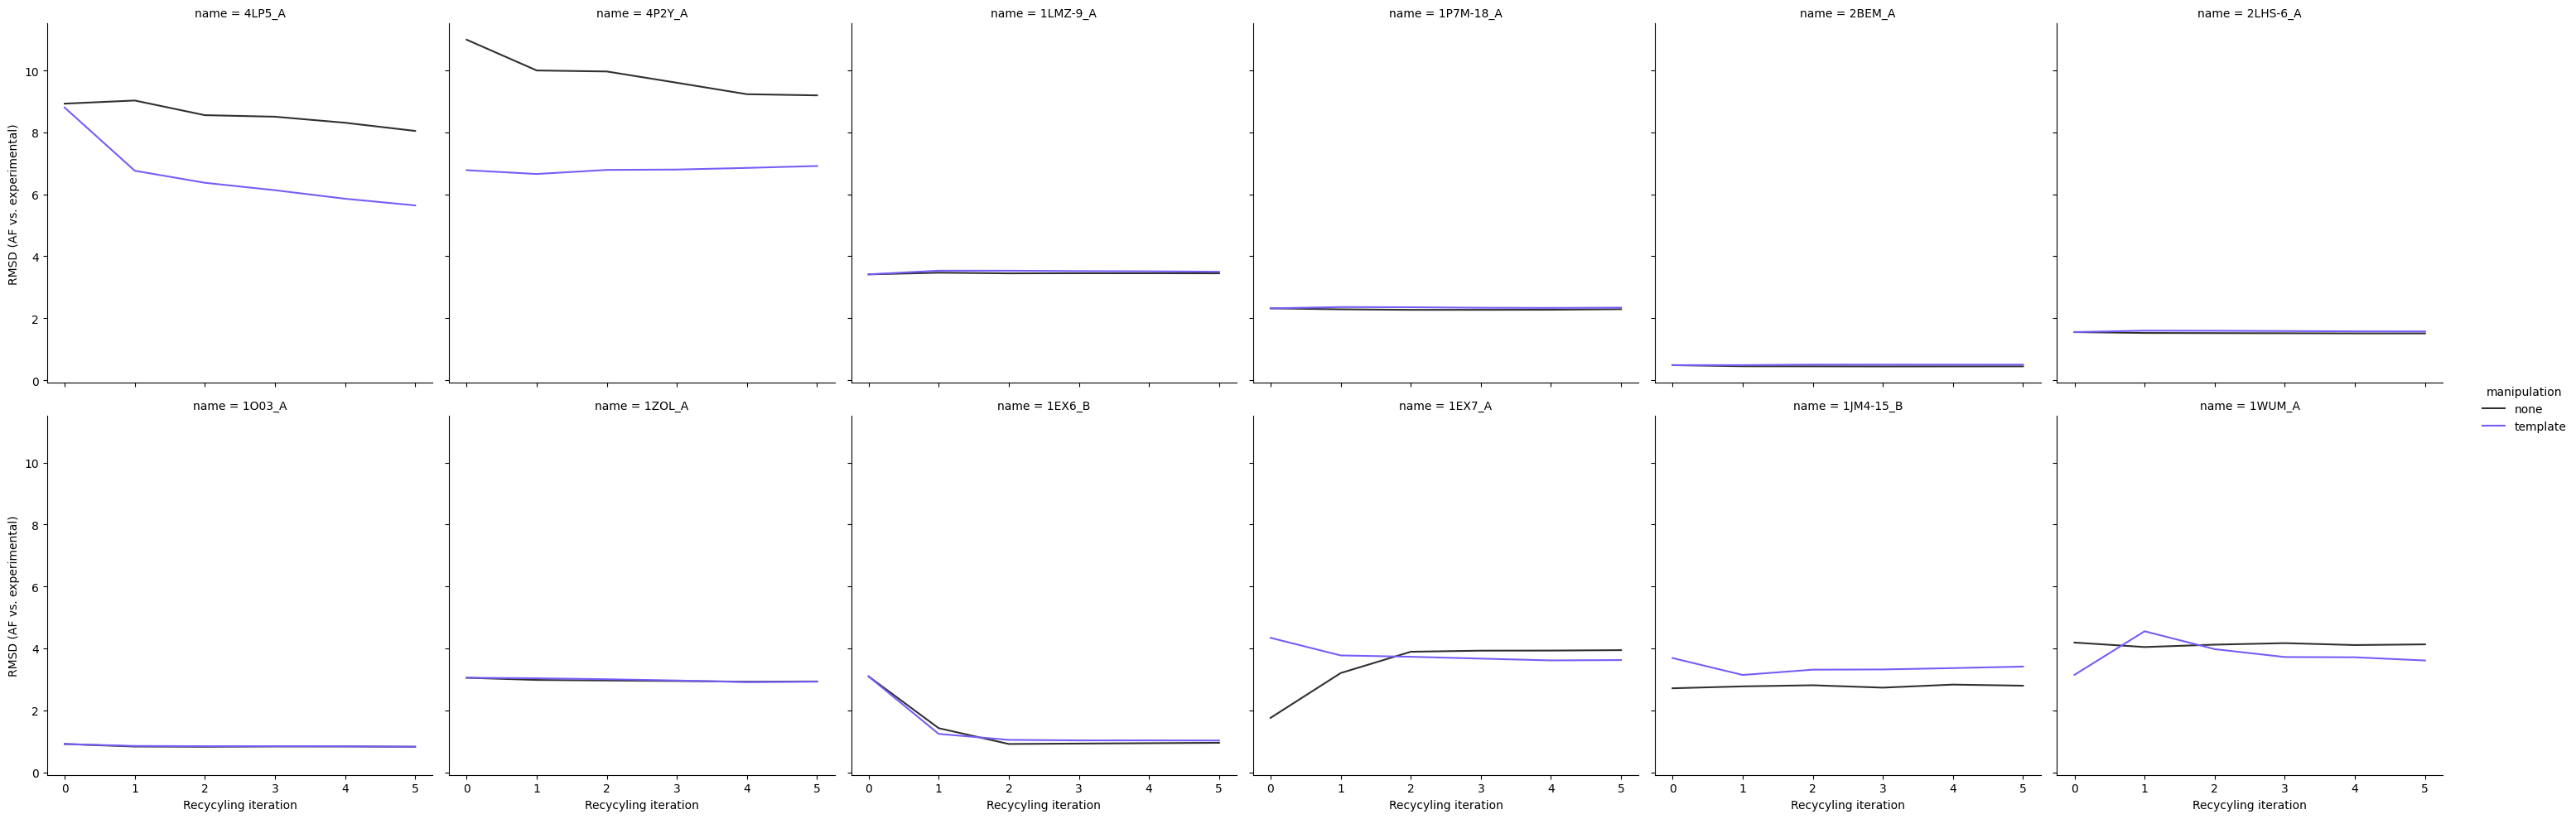

In [54]:
# plot structure similarity across recycling iterations
g = sns.relplot(data=conf_df, 
                x='recycling_iteration',
                y='rmsd_same', 
                col='name', 
                hue='manipulation', 
                col_wrap=6, 
                kind='line', 
                palette=['#303030', '#785cf7'])

(g.set_axis_labels("Recycyling iteration", "RMSD (AF vs. experimental)")
  .tight_layout())

**Structure similarity across recycling iterations**

Each subplot is a single conformation.
y-axis indicates RMSD between the AF output vs. experimental structure (lower values = more similar).
x-axis indicates recycling iterations (0 is after one pass through AF network, 5 is end).
Black lines indicate the AF prediction without any manipulation .
(i.e. same sequence/output for each conformer pair, just two different similarity scores over time).
Purple lines indicate the AF prediction when the experimental structure for that conformer was injected at each recycling iteration.
(i.e. trying to drive alphafold prediction to be more similar to that conformer).

In [6]:
# plot structural similarity of apo vs. holo conformers
g = sns.scatterplot(data=conf_df.query(f'recycling_iteration == 5 '), 
                x='rmsd_same',
                y='rmsd_alt', 
                hue='manipulation',
                alpha=0.5,
                palette=['#303030', '#785cf7'])
g.axline((0, 0), slope=1, c=".2", ls="--", zorder=0)
g.set(xlabel='RMSD AF vs. apo', ylabel='RMSD AF vs. holo')

[Text(0.5, 0, 'RMSD AF vs. apo'), Text(0, 0.5, 'RMSD AF vs. holo')]

In [7]:
# make structure visualization function
def plot_recycling_iteration(df_row, colnames, exp_colname, colors=('blue','purple')):
    for i, c in enumerate(colnames):
        view.addModel(open(df_row[exp_colname], "r").read(), "pdb", viewer=(i, df_row['recycling_iteration']))
        view.addModel(open(df_row[c], "r").read(), "pdb", viewer=(i, df_row['recycling_iteration']))
    
        view.setStyle({'model':0}, {'cartoon':{'color':'white'}}, viewer=(i, df_row['recycling_iteration']))
        view.setStyle({'model':1}, {'cartoon':{'color':colors[i]}}, viewer=(i, df_row['recycling_iteration']))

# visualize structural representations across recycling iterations 
pdb_name = "1EX7_A"
manipulations = ('none', 'template')
exp_colname = 'exp_same_fname'

example_df = (conf_df
              .query(f"name == '{pdb_name}'")
              .pivot(columns='manipulation', values='af_fname', index=['name', exp_colname, 'recycling_iteration'])
              .reset_index()
              .sort_values('recycling_iteration'))

aligned_colnames = [f'{m}_aligned' for m in manipulations]
for m in manipulations:
    example_df[f'{m}_aligned'] = example_df.apply(lambda x: align_structures(x[exp_colname], x[m]), axis=1)
    
view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js", viewergrid=(2, 6))
example_df.apply(lambda x: plot_recycling_iteration(x, aligned_colnames, exp_colname), axis=1)
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

**3D structural representations across recycling iterations**

Each column indicates a recycling iteration (left = start of AF run, right = end)
Top row is the AF structural output without any manipulations (blue = AF prediction, white = experimental structure)
Bottom row is the AF structural output with manipulations (purple = AF prediction, white = experimental structure)

## Correlation between intermediate pair representations and structural outputs

### Data setup

In [4]:
# calc distance between pair representations
def get_euclidean_distance(pair1, pair2):
    with open(pair1, 'rb') as file:
        pair1_data = pickle.load(file)
    with open(pair2, 'rb') as file:
        pair2_data = pickle.load(file)

    # calculate distance between pair representations 
    # note - have to divide and remultiply max bc float16 too small, still some overflow warnings
    diff_a_b = pair1_data['representations']['pair'] - pair2_data['representations']['pair']
    # a_b_max = np.max(diff_a_b) 
    # norm = scipy.linalg.norm(diff_a_b / a_b_max) * a_b_max  
    norm = scipy.linalg.norm(diff_a_b.astype(np.float32))
    distance = norm / np.sqrt(np.size(pair1_data['representations']['pair']))
    
    return distance

def get_cosine_similarity(pair1, pair2):
    with open(pair1, 'rb') as file:
        pair1_data = pickle.load(file)
    with open(pair2, 'rb') as file:
        pair2_data = pickle.load(file)

    # calculate cosine similarity between pair representations 
    a = pair1_data['representations']['pair'].flatten().astype(np.float32)
    b = pair2_data['representations']['pair'].flatten().astype(np.float32)
    similarity = np.dot(a, b) / (scipy.linalg.norm(a) * scipy.linalg.norm(b))
    
    return similarity

def get_similarity_data(seqs, combos):
    distance_data = []
    for i, seq in enumerate(seqs):
        print(f'Calculating distances for {seq} ({i} / {len(seqs)})...')
        for (model1, model2), (recycling1, recycling2) in combos:
            # load intermediate pair representations and structure representations
            struct1 = glob.glob(f'{output_dir}//{seq}*rank_00{model1}*.r{recycling1}.pdb')[0]
            struct2 = glob.glob(f'{output_dir}//{seq}*rank_00{model2}*.r{recycling2}.pdb')[0]

            pair1 = glob.glob(f'{output_dir}//{seq}*rank_00{model1}*.r{recycling1}.pickle')[0]
            pair2 = glob.glob(f'{output_dir}//{seq}*rank_00{model2}*.r{recycling2}.pickle')[0]

            # calculate RMSD between structures
            rmsd = get_rmsd(struct1, struct2)

            # calculate approximate LDDT between structures
            lddt = get_lddt(struct1, struct2)

            # calculate euclidean distance
            distance = get_euclidean_distance(pair1, pair2)
            
            # calculate cosine similarity
            cosine_similarity = get_cosine_similarity(pair1, pair2)

            # add comparison labels
            recycling_comparison = f'{recycling1} vs. {recycling2}'
            model_comparison = f'{model1} vs. {model2}'

            distance_data.append((dict(sequence_name=seq, 
                                       val1_model=model1, 
                                       val2_model=model2, 
                                       val1_recycling=recycling1, 
                                       val2_recycling=recycling2,
                                       recycling_comparison=recycling_comparison,
                                       rmsd=rmsd, 
                                       lddt=lddt,
                                       distance=distance,
                                       cosine_similarity=cosine_similarity)))
    return pd.DataFrame(distance_data)

In [ ]:
# for each model, compare the final output structures
model_combos = list(itertools.combinations(range(1,6), 2))
model_combos = [(c, (5, 5)) for c in model_combos]
model_df = get_similarity_data(pair_df['apo_id'].to_list(), model_combos)
model_df['log_distance'] = np.log(model_df['distance'])
model_df.head()

Calculating distances for 1AEL-12_A (0 / 91)...


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Calculating distances for 1BV2-3_A (1 / 91)...
Calculating distances for 1C54-19_A (2 / 91)...
Calculating distances for 1EAL-2_A (3 / 91)...
Calculating distances for 1F3Y-17_A (4 / 91)...
Calculating distances for 1FMF-4_A (5 / 91)...
Calculating distances for 1GH1-7_A (6 / 91)...
Calculating distances for 1GQN_A (7 / 91)...
Calculating distances for 1GQZ_A (8 / 91)...
Calculating distances for 1HSI_B (9 / 91)...
Calculating distances for 1I56_A (10 / 91)...
Calculating distances for 1IGP_A (11 / 91)...
Calculating distances for 1JFJ-3_A (12 / 91)...
Calculating distances for 1K2H-4_A (13 / 91)...
Calculating distances for 1LIP-2_A (14 / 91)...
Calculating distances for 1MUT-11_A (15 / 91)...
Calculating distances for 1MX7-20_A (16 / 91)...
Calculating distances for 1NTR-7_A (17 / 91)...
Calculating distances for 1O1U-9_A (18 / 91)...
Calculating distances for 1PDB_A (19 / 91)...
Calculating distances for 1TFU_A (20 / 91)...
Calculating distances for 1TJD_A (21 / 91)...
Calculating d

### Visualization

In [171]:
# plots with RMSD vs. pair distance
fig, ax = plt.subplots(figsize=(3, 3))
g = sns.regplot(data=model_df,
               x="distance", 
               y="lddt", 
               ax=ax,
               color='k',
               ci=None,
               scatter_kws={'s':7, 'edgecolors':'white', 'linewidths':0.3}, 
               #scatter_kws={'s':7, 'facecolors':'white', 'edgecolors': 'k', 'linewidths': 0.3}
)
g.figure.suptitle('Correlation between pair representations\n and AlphaFold outputs')
g.set_xlabel('Euclidean distance between \npair representations')
g.set_ylabel('plDDT between \nstructural outputs')
r, p = pearsonr(model_df['distance'], model_df['lddt'])
g.text(.05, .05, '$r^2$ = {:.2f} \np < 0.0001'.format(r**2), transform=g.transAxes)
g.figure.tight_layout()
g.annotate('', xy=(0.3, 0.04), xytext=(1.1, 0.04),  xycoords='figure fraction', arrowprops=dict(arrowstyle='<|-|>'))
ax.annotate('more \nsimilar', xy=(0.2,0.05), xycoords='figure fraction', ha='center', va='center',fontsize=9)
ax.annotate('less \nsimilar', xy=(1.2,0.05), xycoords='figure fraction', ha='center', va='center',fontsize=9)
g.annotate('', xy=(0.1, 0.3), xytext=(0.1, 0.75),  xycoords='figure fraction', arrowprops=dict(arrowstyle='<|-|>'))
g.annotate('more \nsimilar', xy=(0.1, 0.8), xycoords='figure fraction', ha='center', va='center',fontsize=9)
g.annotate('less \nsimilar', xy=(0.1, 0.25), xycoords='figure fraction', ha='center', va='center',fontsize=9)
sns.despine(offset=5)
g.figure.savefig('pair_structure_corr.png', bbox_inches='tight')

**Approach viability: correlation between intermediate representations and AlphaFold outputs.** Global plDDT scores decrease with increased distance between intermediate representations (Pearson correlation -0.58, p-value < 0.0001). Each data point represents a comparison between two AlphaFold models generated from the same sequence (n = 91 sequences, n = 910 individual comparisons (5 models x 2 per comparison x 91 sequences)).

In [28]:
# for each model, compare each recycling iteration
recycling_combos = [(i, i+1) for i in range(5)]
recycling_combos = [((i, i), c) for i in range(1,6) for c in recycling_combos] 
recycling_df = get_similarity_data(pair_df['apo_id'].to_list(), recycling_combos)
recycling_df.head()

Calculating distances for 1AEL-12_A (0 / 91)...
Calculating distances for 1BV2-3_A (1 / 91)...
Calculating distances for 1C54-19_A (2 / 91)...
Calculating distances for 1EAL-2_A (3 / 91)...
Calculating distances for 1F3Y-17_A (4 / 91)...
Calculating distances for 1FMF-4_A (5 / 91)...
Calculating distances for 1GH1-7_A (6 / 91)...
Calculating distances for 1GQN_A (7 / 91)...
Calculating distances for 1GQZ_A (8 / 91)...
Calculating distances for 1HSI_B (9 / 91)...
Calculating distances for 1I56_A (10 / 91)...
Calculating distances for 1IGP_A (11 / 91)...
Calculating distances for 1JFJ-3_A (12 / 91)...
Calculating distances for 1K2H-4_A (13 / 91)...
Calculating distances for 1LIP-2_A (14 / 91)...
Calculating distances for 1MUT-11_A (15 / 91)...
Calculating distances for 1MX7-20_A (16 / 91)...
Calculating distances for 1NTR-7_A (17 / 91)...
Calculating distances for 1O1U-9_A (18 / 91)...
Calculating distances for 1PDB_A (19 / 91)...
Calculating distances for 1TFU_A (20 / 91)...
Calculating

sequence_name  val1_model  val2_model  val1_recycling  val2_recycling  \
0     1AEL-12_A           1           1               0               1   
1     1AEL-12_A           1           1               1               2   
2     1AEL-12_A           1           1               2               3   
3     1AEL-12_A           1           1               3               4   
4     1AEL-12_A           1           1               4               5   

  recycling_comparison      rmsd      lddt  distance  cosine_similarity  
0                 0vs1  0.262049  0.981923  2.411981           0.996727  
1                 1vs2  0.066101  0.998367  1.184137           0.999157  
2                 2vs3  0.029745  1.000000  0.726376           0.999650  
3                 3vs4  0.030091  0.998959  0.711998           0.999670  
4                 4vs5  0.028606  0.999997  0.697618           0.999681

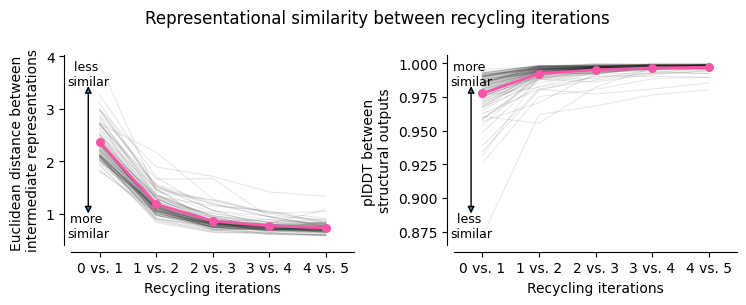

In [169]:
# plots with RMSD/LDDT differences between iterations
value_vars = ['distance', 'lddt']
temp_df = recycling_df.melt(id_vars=['sequence_name', 'recycling_comparison'], 
                            value_vars=value_vars, 
                            value_name='value', 
                            var_name='metric')

g = sns.catplot(
    data=temp_df, x="recycling_comparison", y='value',col='metric', hue='sequence_name', kind='point', 
    capsize=0, errorbar=None, markersize=7, color='k', markers=None, alpha=0.1, linewidth=0.75, legend=False,
    sharey=False, height=3, aspect=1.25
)
ylabels = ['Euclidean distance between \nintermediate representations', 'plDDT between \nstructural outputs',]
for i, ax in enumerate(g.axes[0]):
    sns.pointplot(ax=ax,
        data=recycling_df, x="recycling_comparison", y=value_vars[i],
        capsize=0, errorbar="ci", markersize=5, color='#f654a6', linewidth=2,
    )
    ax.set_xlabel('Recycling iterations')
    ax.set_ylabel(ylabels[i])
    ax.set_title('')
g.fig.suptitle('Representational similarity between recycling iterations')
g.axes[0][0].annotate('', xy=(0.06, 0.15), xytext=(0.06, 0.85),  xycoords='axes fraction', arrowprops=dict(arrowstyle='<|-|>'))
g.axes[0][0].annotate('less \nsimilar', xy=(0.06, 0.9), xycoords='axes fraction', ha='center', va='center',fontsize=9)
g.axes[0][0].annotate('more \nsimilar', xy=(0.06, 0.1), xycoords='axes fraction', ha='center', va='center',fontsize=9)
g.axes[0][1].annotate('', xy=(0.06, 0.15), xytext=(0.06, 0.85),  xycoords='axes fraction', arrowprops=dict(arrowstyle='<|-|>'))
g.axes[0][1].annotate('more \nsimilar', xy=(0.06, 0.9), xycoords='axes fraction', ha='center', va='center',fontsize=9)
g.axes[0][1].annotate('less \nsimilar', xy=(0.06, 0.1), xycoords='axes fraction', ha='center', va='center',fontsize=9)
g.fig.tight_layout()
sns.despine(offset=5)
g.figure.savefig('recycling_changes.png', bbox_inches='tight')

*Representational changes between recycling iterations.* Grey lines indicate comparisons between recycling iterations for an individual model, purple lines indicate average across all models and sequences (n=91 sequences, n = 455 runs (sequences x 5 models))
Left, euclidian distance between intermediate pair representations.
Right, plDDT between structural outputs